## Latent Dirichlet Allocation

In [1]:
from octis.models.LDA import LDA
from octis.dataset.dataset import Dataset
from octis.evaluation_metrics.diversity_metrics import TopicDiversity
from octis.evaluation_metrics.coherence_metrics import Coherence
from octis.optimization.optimizer import Optimizer
from skopt.space.space import Real, Integer
import numpy as np
import time
import matplotlib.pyplot as plt
import json
from tqdm import tqdm

In [2]:
# Load the dataset
dataset = Dataset()  
dataset.fetch_dataset("BBC_News")
#dataset.load_custom_dataset_from_folder("data/processed") # Our custom preprocessed dataset

Make sure that the dataset is in the following format:
corpus file: a .tsv file (tab-separated) that contains up to three columns, i.e. the document, the partitition, and the label associated to the document (optional).
vocabulary: a .txt file where each line represents a word of the vocabulary
The partition can be "train" for the training partition, "test" for testing partition, or "val" for the validation partition. An example of dataset can be found here: sample_dataset.



In [3]:
# Some data exploration
print(len(dataset._Dataset__corpus))
print(len(dataset._Dataset__vocabulary))
print(dataset._Dataset__corpus[1])

2225
2949
['plan', 'share', 'sale', 'owner', 'technology', 'dominate', 'index', 'plan', 'sell', 'share', 'public', 'list', 'market', 'operate', 'accord', 'document', 'file', 'stock', 'market', 'plan', 'raise', 'sale', 'observer', 'step', 'close', 'full', 'public', 'icon', 'technology', 'boom', 'recently', 'pour', 'cold', 'water', 'suggestion', 'company', 'sell', 'share', 'private', 'technically', 'public', 'stock', 'start', 'trade', 'list', 'equity', 'trade', 'money', 'sale', 'investor', 'buy', 'share', 'private', 'filing', 'document', 'share', 'technology', 'firm', 'company', 'high', 'growth', 'potential', 'symbol', 'internet', 'telecom', 'boom', 'bubble', 'burst', 'recovery', 'fortune', 'tech', 'giant', 'dot', 'revive', 'fortune']


## Metrics

In [4]:
td, ch = TopicDiversity(topk=10), Coherence(topk=10, measure = 'c_v') # Initialize metric

## Without optimization

In [5]:
# Create Model
model = LDA(num_topics=20)

In [6]:
coherence_list_no_opt, topic_diversity_list_no_opt, iters = [], [], 100

for i in tqdm(range(iters)):
  output = model.train_model(dataset)
  coherence_list_no_opt.append(ch_score := ch.score(output))
  topic_diversity_list_no_opt.append(td_score := td.score(output))

print("Mean coherence: ", np.mean(coherence_list_no_opt), "\nMean topic diversity: ", np.mean(topic_diversity_list_no_opt))

100%|██████████| 100/100 [06:05<00:00,  3.66s/it]

Mean coherence:  0.4088191258553374 
Mean topic diversity:  0.33175000000000004


## With optimization

In [7]:
model = LDA()

In [8]:
# Optimization for hyperparameters based on coherence (to be substituted with a combination of ch e td ?)


# Define the search space. To see which hyperparameters to optimize, see the topic model's initialization signature
search_space = {"num_topics": Integer(low=5, high=50),
                "offset": Integer(low=1, high=100)}

# Initialize an optimizer object and start the optimization.
optimizer=Optimizer()

In [9]:

start = time.time() # Just to see, to be removed.

# This uses the default optimization method (Bayesian optimization) and the default metric (coherence) to optimize the model, try also random search.

optResult=optimizer.optimize(model, dataset, ch, search_space, save_path="results/test_LDA", # path to store the results
                            number_of_call=30, # number of optimization iterations: rule of thumb 15*num_hyperparameters
                            model_runs=5, # number of runs of the topic model: can be increased but takes more time
                            plot_best_seen=True, # plot the best seen value of the metric
                            extra_metrics = None,
                            plot_model=True, # plot the topic model
                            early_step=10, # number of iterations after which the optimization stops if no improvement
                            surrogate_model='GP', # surrogate model for the optimization: gaussian process
                            random_state=123)

#save the results of th optimization in a csv file
optResult.save_to_csv("results.csv")

end = time.time()
duration = end - start

print('Optimizing model took: ' + str(round(duration)) + ' seconds.')

Current call:  0
Current call:  1
Current call:  2
Current call:  3
Current call:  4
Current call:  5
Current call:  6
Current call:  7
Current call:  8
Current call:  9
Current call:  10
Current call:  11
Current call:  12
Current call:  13
Current call:  14
Current call:  15
Current call:  16
Current call:  17
Current call:  18
Current call:  19
Current call:  20
Current call:  21
Current call:  22
Current call:  23
Current call:  24
Current call:  25
Current call:  26
Current call:  27
Current call:  28
Current call:  29
Optimizing model took: 639 seconds.


In [10]:
results = json.load(open("results/test_LDA/result.json",'r'))
results.keys()

dict_keys(['dataset_name', 'dataset_path', 'is_cached', 'kernel', 'acq_func', 'surrogate_model', 'optimization_type', 'model_runs', 'save_models', 'save_step', 'save_name', 'save_path', 'early_stop', 'early_step', 'plot_model', 'plot_best_seen', 'plot_name', 'log_scale_plot', 'search_space', 'model_name', 'model_attributes', 'use_partitioning', 'metric_name', 'extra_metric_names', 'metric_attributes', 'extra_metric_attributes', 'current_call', 'number_of_call', 'random_state', 'x0', 'y0', 'n_random_starts', 'initial_point_generator', 'topk', 'time_eval', 'dict_model_runs', 'f_val', 'x_iters'])

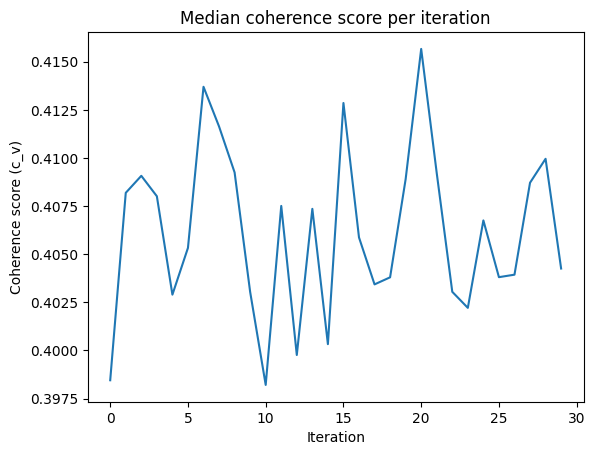

In [11]:
plt.xlabel('Iteration')
plt.ylabel('Coherence score (c_v)')
plt.title('Median coherence score per iteration')
plt.plot(results["f_val"])
plt.show()

In [12]:
max_index = results["f_val"].index(max(results["f_val"]))
results["f_val"][max_index]

0.4156644946848382

In [13]:
print(results["x_iters"].keys())
print([results["x_iters"][parameter][10] for parameter in results["x_iters"].keys()])

num_topics = results["x_iters"]["num_topics"][max_index]
offset = results["x_iters"]["offset"][max_index]

dict_keys(['num_topics', 'offset'])
[28, 100]


Now we're ready to train it. See that the output of a topic model comes as a dictionary composed of 4 elements:


*   *topics*: the list of word topics
*   *topic-word-matrix*: the distribution of the words of the vocabulary for each topic (dimensions: |num topics| x |vocabulary|)
*   *topic-document-matrix*: the distribution of the topics for each document of the training set (dimensions: |num topics| x |training documents|)
*   *test-document-topic-matrix*: the distribution of the topics for each document of the testing set (dimensions: |num topics| x |test documents|)



In [14]:
model = LDA(num_topics=num_topics, decay = 0.7, offset=offset)

In [15]:
# Train the model using default partitioning choice
output = model.train_model(dataset)

print(*list(output.keys()), sep="\n") # Print the output identifiers

topic-word-matrix
topics
topic-document-matrix
test-topic-document-matrix


For  examples, these are a sample of 5 topics. Do you think they make sense?

In [16]:
for t in output['topics'][:5]:
  print(" ".join(t))

game mobile phone firm service company add win technology play
play show win player add game government sale club include
win film government show good world plan home service week
good government win market month game company back award show
good game play work number company win give back week


To check if the topics are coherent, we can use a topic coherence measure. The most used one is NPMI and it is available in OCTIS. We are going to use the dataset itself to compute it.

Or we can test if the resulting topics are different from each other. The `TopicDiversity` measure computes the number of unique words in the top-words of the resulting topics.



And with the method `score`, we can get their actual evaluation score. Just use the output of the topic model as input of the method.

In [17]:
coherence_list, topic_diversity_list, iters = [], [], 100

for i in tqdm(range(iters)):
  output = model.train_model(dataset)
  coherence_list.append(ch_score := ch.score(output))
  topic_diversity_list.append(td_score := td.score(output))

print("Mean coherence: ", np.mean(coherence_list), "\nMean topic diversity: ", np.mean(topic_diversity_list))

100%|██████████| 100/100 [04:35<00:00,  2.76s/it]

Mean coherence:  0.40980172286456307 
Mean topic diversity:  0.5516000000000002


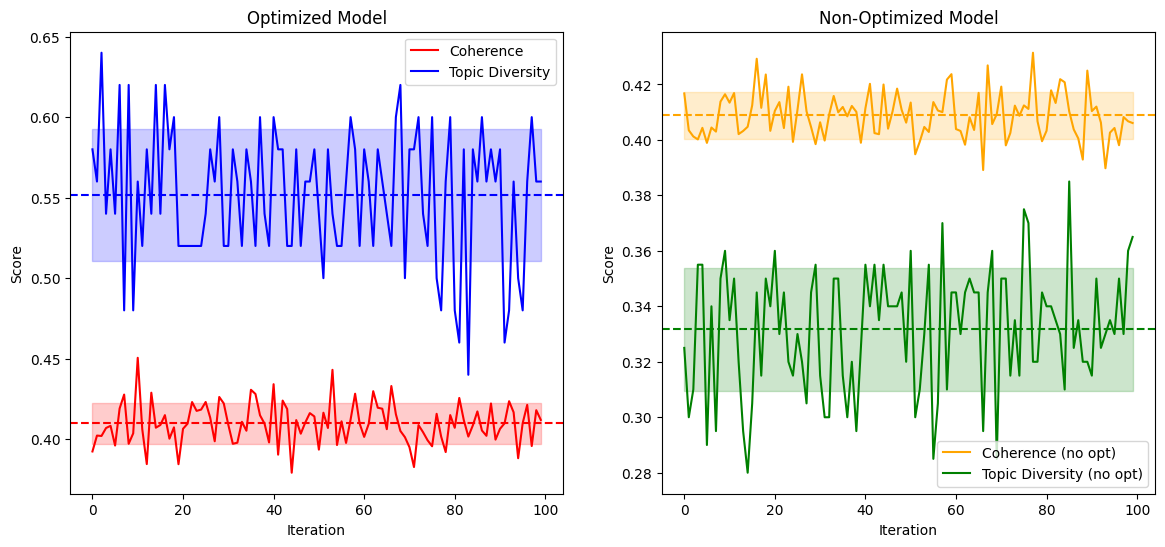

In [18]:
# Plotting the coherence and topic diversity scores over the iterations, the mean values for both and also their variance for both the optmized and non-optimized models

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Plot for optimized model
ax1.plot(range(iters), coherence_list, label="Coherence", color='red')
ax1.plot(range(iters), topic_diversity_list, label="Topic Diversity", color='blue')
ax1.axhline(np.mean(coherence_list), color='red', linestyle='--')
ax1.axhline(np.mean(topic_diversity_list), color='blue', linestyle='--')
ax1.fill_between(range(iters), np.mean(coherence_list) - np.std(coherence_list), np.mean(coherence_list) + np.std(coherence_list), color='red', alpha=0.2)
ax1.fill_between(range(iters), np.mean(topic_diversity_list) - np.std(topic_diversity_list), np.mean(topic_diversity_list) + np.std(topic_diversity_list), color='blue', alpha=0.2)
ax1.set_xlabel("Iteration")
ax1.set_ylabel("Score")
ax1.set_title("Optimized Model")
ax1.legend()

# Plot for non-optimized model
ax2.plot(range(iters), coherence_list_no_opt, label="Coherence (no opt)", color='orange')
ax2.plot(range(iters), topic_diversity_list_no_opt, label="Topic Diversity (no opt)", color='green')
ax2.axhline(np.mean(coherence_list_no_opt), color='orange', linestyle='--')
ax2.axhline(np.mean(topic_diversity_list_no_opt), color='green', linestyle='--')
ax2.fill_between(range(iters), np.mean(coherence_list_no_opt) - np.std(coherence_list_no_opt), np.mean(coherence_list_no_opt) + np.std(coherence_list_no_opt), color='orange', alpha=0.2)
ax2.fill_between(range(iters), np.mean(topic_diversity_list_no_opt) - np.std(topic_diversity_list_no_opt), np.mean(topic_diversity_list_no_opt) + np.std(topic_diversity_list_no_opt), color='green', alpha=0.2)
ax2.set_xlabel("Iteration")
ax2.set_ylabel("Score")
ax2.set_title("Non-Optimized Model")
ax2.legend()

plt.show()